# Cant use the same method as we used for affine transformations

### The code just creates another affine transformation

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2

In [34]:
greyImage = r'albert-einstein_gray.jpg'
colourImage = r'tulips.jpg'
affineWarped = r'affine-transformed image.jpg'
projectiveWarped = r'projective_transformed.jpg'

In [36]:
I_grey = cv2.imread(greyImage,cv2.IMREAD_GRAYSCALE)
I_BGR = cv2.imread(colourImage)
I_affineWarped = cv2.imread(affineWarped,cv2.IMREAD_GRAYSCALE)
I_projectiveWarped = cv2.imread(projectiveWarped,cv2.IMREAD_GRAYSCALE)

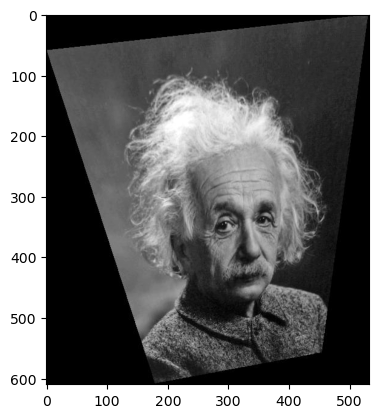

In [38]:
plt.imshow(I_projectiveWarped,cmap='gray')

In [40]:
def displayImageInActualSize(I):
    dpi = mpl.rcParams['figure.dpi']
    H,W = I.shape
    figSize = W/float(dpi) , H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(I,cmap='gray')
    plt.show

In [42]:
def f_bilinearInterpolate(r,c,I):
    lc = int(c)
    rc = lc+1
    wr = c - lc
    wl = rc - c
    tr = int(r)
    br = tr+1
    wt = br-r
    wb = r-tr
    if tr >= 0 and br < I.shape[0] and lc >=0 and rc < I.shape[1]:
        a = wl*I[tr,lc] + wr*I[tr,rc]
        b = wl*I[br,lc] + wr*I[br,rc]
        g = wt*a + wb*b
        return np.uint8(g)
    else:
        return 0

In [44]:
def f_getExtentsProjective(T,rMax,cMax):
    coords = np.array([[0,0,1],[0,cMax-1,1],[rMax-1,0,1],[rMax-1,cMax-1,1]])
    A_dash = T.dot(coords.T)
    A_dash = A_dash/A_dash[2,:]
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H,W = maxR-minR+1, maxC-minC+1
    return minR,minC,maxR,maxC,H,W

In [46]:
def f_transformProjective(T,I_grey):
    rMax,cMax = I_grey.shape[0],I_grey.shape[1]
    minR,minC,maxR,maxC,H,W = f_getExtentsProjective(T,rMax,cMax)
    I2 = np.zeros((H,W),dtype='uint8')
    Tinv = np.linalg.inv(T)
    for new_i in range(minR,maxR):
        for new_j in range(minC,maxC):
            P_dash = np.array([new_i,new_j,1])
            P = Tinv.dot(P_dash)
            P = P/P[2]
            i , j = P[0] , P[1]
            if i < 0 or i>=rMax or j<0 or j>=cMax:
                pass
            else:
                g = f_bilinearInterpolate(i,j,I_grey)
                I2[new_i-minR,new_j-minC] = g
    return I2

In [48]:
# function to mark points
def f_getPoints(I,numPts): # image and how many points we want to mark
    %matplotlib
    fig,ax = plt.subplots(1,figsize=(15,30))
    plt.imshow(I,cmap='gray')
    pts = np.round(np.array(plt.ginput(n=numPts))) # returns points in matrix form, where first colum represents x coordinate and second the y. 
    pts = pts[:,[1,0]].T # shifting and transposing to get first row as row coordinate and second as colum coordinate of the points
    plt.close()
    return pts

## Direct Linear Transform

### finding the null space using eigenvalue decomposition

In [52]:
def computeRightNullSpace(A):
    B = A.T.dot(A)
    w,v = np.linalg.eig(B)  # calculating eigenvalues and eigenvectors of B
    idx = np.argmin(w)  #index for minimum eigenvalue
    nullVector = v[:,idx]
    return nullVector

#### quick test

In [104]:
A = np.random.rand(3,4) # generating a random 3 by 4 matrix

In [106]:
nv = computeRightNullSpace(A)

In [108]:
nv

array([ 0.50924006,  0.17669109, -0.15868164, -0.82720914])

In [110]:
A.dot(nv)

array([ 0.00000000e+00,  5.55111512e-16, -1.11022302e-16])

#### dlt implementation

In [86]:
def computeRightNullSpace(A):
    B = A.T.dot(A)
    w,v = np.linalg.eig(B)  # calculating eigenvalues and eigenvectors of B
    idx = np.argmin(w)  #index for minimum eigenvalue
    nullVector = v[:,idx]
    return nullVector

In [88]:
# marking points on original image
P = f_getPoints(I_grey, 4)

Using matplotlib backend: QtAgg


In [90]:
# marking same points on transformed image
P_dash = f_getPoints(I_projectiveWarped,4)

Using matplotlib backend: QtAgg


In [92]:
# converting to homogenous coordinates
P = np.vstack((P,np.ones((1,4)))) # adding a row of ones to bottom
P_dash = np.vstack((P_dash,np.ones((1,4)))) # adding a row of ones to bottom

In [94]:
# creating an empty matrix A
A = np.zeros((8,9))

In [96]:
A[::2,:3] = -P.T # every other row and first 3 columns
A[1::2,3:6] = -P.T # opposite every other row and the next 3 columns
A[::2,6:] = P.dot(np.diag(P_dash[0,:])).T
A[1::2,6:] = P.dot(np.diag(P_dash[1,:])).T

In [98]:
h = computeRightNullSpace(A)

In [100]:
h

array([-2.05663031e-02,  1.35334706e-03, -9.98708622e-01, -6.31487885e-03,
       -1.36910499e-02, -4.02435254e-02, -1.70412316e-05, -1.78863929e-06,
       -1.75903451e-02])

In [102]:
H = np.reshape(h,(3,3))

In [104]:
H

array([[-2.05663031e-02,  1.35334706e-03, -9.98708622e-01],
       [-6.31487885e-03, -1.36910499e-02, -4.02435254e-02],
       [-1.70412316e-05, -1.78863929e-06, -1.75903451e-02]])

In [106]:
# trasnform I_grey using H
I2 = f_transformProjective(H,I_grey)

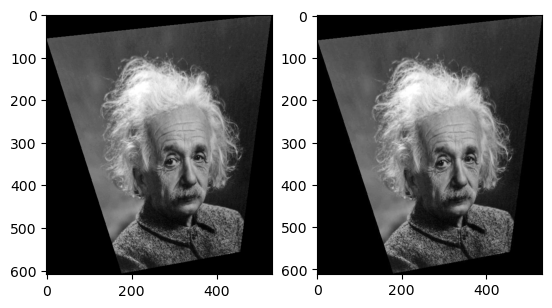

In [108]:
# comparing side by side
%matplotlib inline
plt.subplot(121)
plt.imshow(I2,cmap='gray')
plt.subplot(122)
plt.imshow(I_projectiveWarped,cmap='gray')

## Marking 6 points

#### marking more points makes the transformation more accurate as projective transformations are very sensitive to how accurately you pick your points

Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg


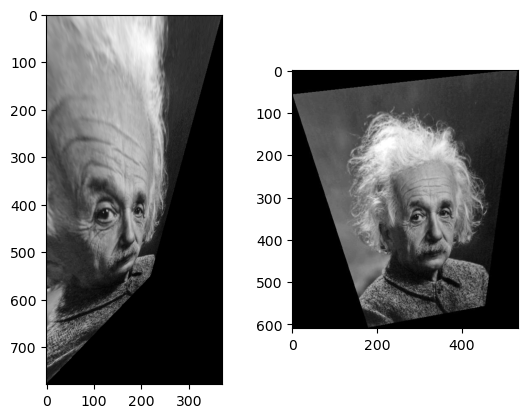

In [29]:
def computeRightNullSpace(A):
    B = A.T.dot(A)
    w,v = np.linalg.eig(B)  # calculating eigenvalues and eigenvectors of B
    idx = np.argmin(w)  #index for minimum eigenvalue
    nullVector = v[:,idx]
    return nullVector
    
# marking points on original image
P = f_getPoints(I_grey, 6)
# marking same points on transformed image
P_dash = f_getPoints(I_projectiveWarped,6)
# converting to homogenous coordinates
P = np.vstack((P,np.ones((1,6)))) # adding a row of ones to bottom
P_dash = np.vstack((P_dash,np.ones((1,6)))) # adding a row of ones to bottom
# creating an empty matrix A
A = np.zeros((12,9))
A[::2,:3] = -P.T # every other row and first 3 columns
A[1::2,3:6] = -P.T # opposite every other row and the next 3 columns
A[::2,6:] = P.dot(np.diag(P_dash[0,:])).T
A[1::2,6:] = P.dot(np.diag(P_dash[1,:])).T
h = computeRightNullSpace(A)
H = np.reshape(h,(3,3))
# trasnform I_grey using H
I2 = f_transformProjective(H,I_grey)
# comparing side by side
%matplotlib inline
plt.subplot(121)
plt.imshow(I2,cmap='gray')
plt.subplot(122)
plt.imshow(I_projectiveWarped,cmap='gray')

## quiz: copy a projective transformation from one image to another

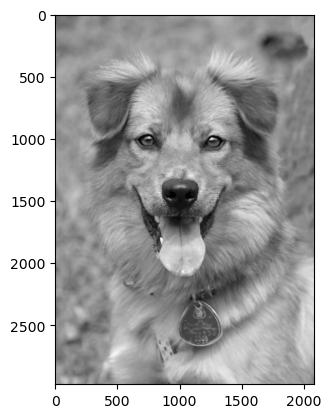

In [110]:
dog = r'dog.jpg'
I_dog = cv2.imread(dog,cv2.IMREAD_GRAYSCALE)
plt.imshow(I_dog,cmap='gray')

In [112]:
I3 = f_transformProjective(H,I_dog)

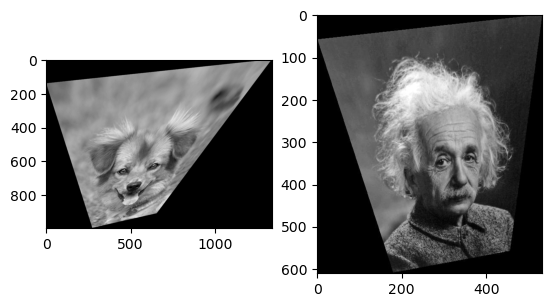

In [113]:
%matplotlib inline
plt.subplot(121)
plt.imshow(I3,cmap='gray')
plt.subplot(122)
plt.imshow(I_projectiveWarped,cmap='gray')